# Analogies
This notebook investigates analogies between wordvectors.
As input, we use a file with embeddings generated by [embiggen](https://pypi.org/project/embiggen/]) together
with a file with the corresponding word labels.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.spatial.distance import cosine
from collections import defaultdict
from sklearn.cluster import DBSCAN


The following code allows us to import the ``kcet`` module from the local repository.

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
from kcet import Wordvec2Cosine

The constructor of ``Wordvec2Cosine`` loads the word embeddings and words into a pandas dataframe.

In [3]:
data_directory = 'data'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_before2021_jan17.npy")
words_file = os.path.join(data_directory, "words_before2021_jan17.txt")
w2c = Wordvec2Cosine(embeddings=embedding_file, words=words_file)
df = w2c.get_embeddings()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,4.889051,-0.031666,0.338668,-3.837982,5.064051,3.183400,-7.890838,5.760468,-2.252833,-5.960526,...,4.204287,-0.621916,5.796295,-4.361966,-3.195167,4.308964,0.216601,-1.855917,-3.194237,0.313202
patient,3.924797,0.219617,0.953061,-4.449959,5.459194,4.111465,-8.687608,3.530771,-2.323123,-4.462675,...,2.524319,0.027388,7.379459,-5.720111,-4.482318,4.162126,1.568093,-0.978158,-3.376686,-0.109741
meshd009369,3.881120,-0.227235,0.395009,-3.596462,5.173261,3.809950,-8.075894,5.201393,-2.407287,-5.387233,...,4.061015,-0.497528,5.869024,-5.586808,-4.170487,4.449340,1.306108,-1.738820,-5.368866,0.187094
0,3.055454,-0.263832,0.920612,-4.864516,5.052263,4.029271,-8.058578,4.390298,-2.375837,-5.064628,...,2.799726,-0.442358,6.306581,-4.008514,-4.170806,4.458221,1.918985,-2.458562,-3.410570,-0.178341
study,3.177587,0.394009,0.676511,-3.332552,4.960812,3.781860,-7.468229,5.013127,-2.291365,-4.292953,...,2.137289,-0.415919,6.394296,-4.925942,-3.313363,2.946915,0.932657,-1.803408,-3.578388,-0.246187


## Embeddings of 4 words ;"Chemotherapy", "Cancer", "Antibiotic", "Infection"

In [4]:
df_4_words = df.loc[["chemotherapy","antibiotic","cancer","infection"]]

In [5]:
df_4_words

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
chemotherapy,2.997501,0.282066,0.621691,-4.011807,5.455760,3.493559,-8.377844,4.800207,-2.286860,-3.903146,...,3.710374,0.101824,9.645905,-7.509939,-1.012129,4.465632,1.978236,-1.402921,-4.013463,-0.098858
antibiotic,2.409722,0.025176,1.092778,-3.642050,5.461978,3.768773,-7.187252,3.243274,-2.603631,-4.182051,...,3.617260,0.136200,6.714638,-4.300593,-2.185653,3.560590,3.328771,-0.021389,-3.006284,-0.460470
cancer,3.929437,0.715188,0.531940,-3.076856,4.415325,3.490265,-5.890310,5.059984,-2.389435,-4.162737,...,3.311719,-0.223730,7.317788,-5.703153,-4.156117,4.038622,1.196362,-1.057779,-5.139115,0.056108
infection,1.990806,-0.745263,1.390847,-3.600788,5.932709,4.137437,-7.203139,4.320743,-2.215029,-5.340410,...,5.110955,-0.931290,5.357444,-5.401697,-2.561577,1.529675,3.492665,-0.670013,-4.603220,0.041047


# PCA visualization

In [6]:
cvec=["red","orange","blue","green"]

In [7]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_4_words.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.51531225 0.32974193 0.15494585]


Text(0, 0.5, 'PC 2 (32.97%)')

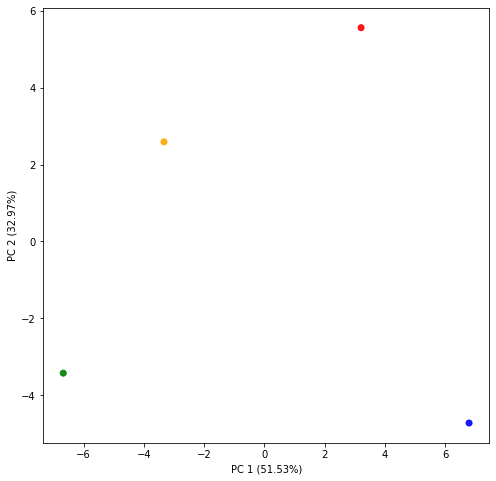

In [8]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0], pca_result[:,1],c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [9]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_4_words)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 3 nearest neighbors...
[t-SNE] Indexed 4 samples in 0.000s...
[t-SNE] Computed neighbors for 4 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 4 / 4
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.718460
[t-SNE] KL divergence after 300 iterations: 0.052948
t-SNE done! Time elapsed: 0.08791399002075195 seconds


Text(0, 0.5, 'tsne-2d-two')

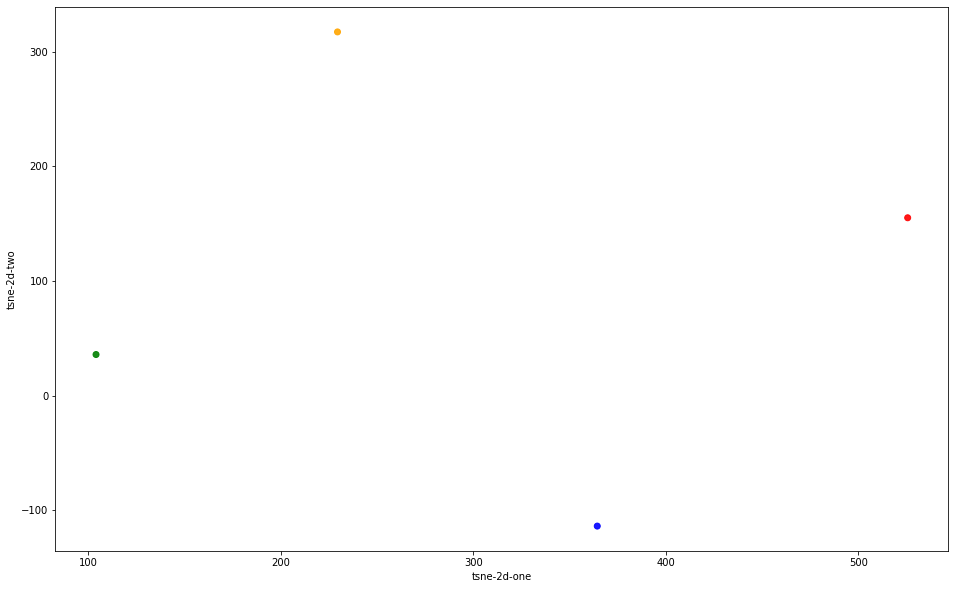

In [10]:
plt.figure(figsize=(16,10))
points = ["chemotherapy", "antibiotic","cancer","infection"]
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec,  alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')
